#### Agenda
- Image load
- Analyze/EDA
- Map image and annotations Raw -- DF
- Resize with annotations - Single image wise (img dim as input)
- Resized Image to np array for model - Single Image wise - X as image, y as model, c as coordinates
- Augment , resized image and send to np array - single image wise - X as image, y as model, c as coordinates

- End Goal - Data set with real and augmented images in np array with expected img size

In [1]:
#setting for resizing all to uniform size and reducing memory utilization
img_height=100
img_width=100

In [2]:
import sys
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
   

from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout
from PIL import Image
import gc

import tensorflow
tensorflow.__version__

Using TensorFlow backend.


'2.1.0'

- Setting path for folders

In [3]:
path1='data/Car Images-20210501T094840Z-001/Car Images/Train Images'
path2='data/Car Images-20210501T094840Z-001/Car Images/Test Images'
path3='data\Annotations-20210510T185520Z-001\Annotations'
# fetching all directories list

dirList=next(os.walk(path1))[1]
dirList.sort()
dirList

['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi A5 Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi S4 Sedan 2007',
 'Audi S4 Sedan 2012',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S6 Sedan 2011',
 'Audi TT Hatchback 2011',
 'Audi TT RS Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi V8 Sedan 1994',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3 SUV 2012',
 'BMW X5 SUV 2007',
 'BMW X6

In [4]:
# capturing details of subdirectories of desired folder
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

In [5]:
cat_Folder_list=get_immediate_subdirectories(path1)
cat_Folder_list2=get_immediate_subdirectories(path2)

In [6]:
# get file and folder details and move those details to a data frame for further use

def getFileDetails_df(path,folderList):
    totalImg=0
    df_overview=pd.DataFrame(columns=['Car Details','No of Images'])
    df_FileDetails=pd.DataFrame(columns=['file_name','fol_details'])
    for img in folderList:
        c1=len(os.listdir(os.path.join(path, img)))
        df_overview=df_overview.append({'Car Details': img ,'No of Images' : c1},ignore_index=True)
        for filename in os.listdir(os.path.join(path, img)):
            df_FileDetails=df_FileDetails.append({'file_name':filename,'fol_details':img},ignore_index=True)
        #print('{}   -->   {} training images'.format(img, len(os.listdir(os.path.join(path1, img)))))
        totalImg+=c1

    print('Total Images:',totalImg)  
    return df_overview,df_FileDetails
    


In [7]:
df_overviewTest, df_testFiles=getFileDetails_df(path2,cat_Folder_list2)
df_overviewTrain, df_trainFiles=getFileDetails_df(path1,cat_Folder_list)

Total Images: 8041
Total Images: 8144


- Tota test images are  - 8041
- Total train images are  - 8144

###### Viewsing number of samples in train and test folders

In [8]:
df_overviewTest.sample(5)

,Car Details,No of Images
139,Hyundai Veracruz SUV 2012,42
165,MINI Cooper Roadster Convertible 2012,36
48,Buick Regal GS 2012,35
159,Mercedes-Benz 300-Class Convertible 1993,48
51,Cadillac Escalade EXT Crew Cab 2007,44


In [9]:
df_overviewTrain.sample(5)

,Car Details,No of Images
98,Ferrari 458 Italia Convertible 2012,40
78,Chrysler PT Cruiser Convertible 2008,45
59,Chevrolet Express Cargo Van 2007,30
84,Dodge Caravan Minivan 1997,44
164,Mercedes-Benz Sprinter Van 2012,41


In [10]:
df_overviewTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Car Details   196 non-null    object
 1   No of Images  196 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [11]:
max(df_overviewTrain['No of Images'])

68

In [12]:
max(df_overviewTest['No of Images'])

68

In [13]:
df_overviewTrain['No of Images'].value_counts()

44    27
43    26
45    24
42    22
41    20
39    15
40    12
46    10
38     7
37     6
36     5
34     4
33     3
35     3
48     2
47     2
31     1
30     1
49     1
68     1
24     1
28     1
29     1
32     1
Name: No of Images, dtype: int64

In [14]:
df_overviewTest['No of Images'].value_counts()

42    32
44    26
43    24
41    19
45    14
40    14
39    13
38    11
46     8
36     7
35     5
37     5
33     3
34     3
32     3
29     2
48     2
47     1
68     1
24     1
27     1
30     1
Name: No of Images, dtype: int64

In [15]:
df_overviewTrain.loc[df_overviewTrain['No of Images']==68]

,Car Details,No of Images
120,GMC Savana Van 2012,68


In [16]:
df_overviewTrain.loc[df_overviewTrain['No of Images']==24]

,Car Details,No of Images
129,Hyundai Accent Sedan 2012,24


In [17]:
df_overviewTest.loc[df_overviewTest['No of Images']==68]

,Car Details,No of Images
120,GMC Savana Van 2012,68


In [18]:
df_overviewTest.loc[df_overviewTest['No of Images']==24]

,Car Details,No of Images
129,Hyundai Accent Sedan 2012,24


<AxesSubplot:xlabel='No of Images'>

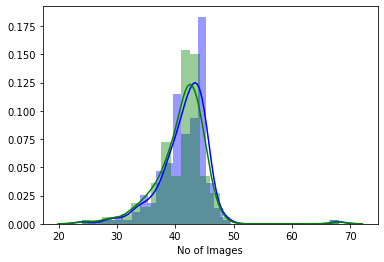

In [19]:
sns.distplot(df_overviewTrain['No of Images'],color='b')
sns.distplot(df_overviewTest['No of Images'],color='g')

- We have a wide distribution of car images across the folders
- Min number of images in a folder is 24 and maximum 68, similar pattern is visible in train and test directories
- distribution are similar for train and test images

###### Putting together annotations

In [20]:
df_annotations_train = pd.read_csv(os.path.join(path3, 'Train Annotations.csv'))
df_annotations_test  = pd.read_csv(os.path.join(path3, 'Test Annotation.csv'))

In [21]:
cols=['file_name','x1','y1','x2','y2','class_Id']
df_annotations_train.columns=cols
df_annotations_test.columns=cols

In [22]:
df_annotations_train.sample(5)

,file_name,x1,y1,x2,y2,class_Id
7886,07887.jpg,27,48,279,175,134
7272,07273.jpg,22,23,376,244,16
7789,07790.jpg,12,21,631,385,102
6909,06910.jpg,213,138,588,390,101
6700,06701.jpg,51,14,560,409,47


In [23]:
df_annotations_test.sample(5)

,file_name,x1,y1,x2,y2,class_Id
131,00132.jpg,29,23,462,332,69
2129,02130.jpg,56,59,268,181,22
5928,05929.jpg,41,81,270,159,67
566,00567.jpg,116,170,757,445,147
1336,01337.jpg,39,166,739,471,13


###### Merging image annotations with details

In [24]:
df_train = pd.merge(df_trainFiles,df_annotations_train,on='file_name')
df_test  = pd.merge(df_testFiles,df_annotations_test,on='file_name')

In [25]:
df_train.head(5)

,file_name,fol_details,x1,y1,x2,y2,class_Id
0,00198.jpg,Acura Integra Type R 2001,91,121,574,357,6
1,00255.jpg,Acura Integra Type R 2001,29,78,734,396,6
2,00308.jpg,Acura Integra Type R 2001,16,136,775,418,6
3,00374.jpg,Acura Integra Type R 2001,9,184,740,499,6
4,00878.jpg,Acura Integra Type R 2001,101,162,882,650,6


In [26]:
df_test.head(5)

,file_name,fol_details,x1,y1,x2,y2,class_Id
0,00128.jpg,Acura Integra Type R 2001,122,149,743,455,6
1,00130.jpg,Acura Integra Type R 2001,27,74,774,449,6
2,00386.jpg,Acura Integra Type R 2001,86,184,723,425,6
3,00565.jpg,Acura Integra Type R 2001,15,1,545,347,6
4,00711.jpg,Acura Integra Type R 2001,126,65,735,347,6


In [27]:
def getImage(path,df,i):
    im = cv2.imread(str('{}/{}/{}'.format(path, df.fol_details[i],df.file_name[i])))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

In [28]:
def viewImageWithBounding(path,df,i):
    im = getImage(path,df,i)
    cv2.rectangle(im,( int(df.x1[i]),int(df.y1[i])), (int(df.x2[i]),int(df.y2[i])), (0,255,0), 2)

    plt.imshow(im)

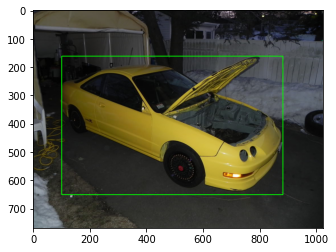

In [29]:
viewImageWithBounding(path1,df_train,4)

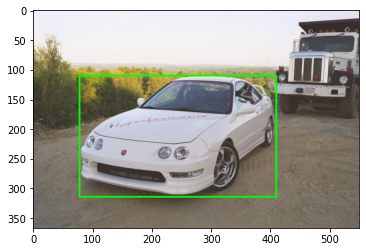

In [30]:
viewImageWithBounding(path2,df_test,9)

- Image size are varying for many images

In [31]:
df_trainFiles.head()

,file_name,fol_details
0,00198.jpg,Acura Integra Type R 2001
1,00255.jpg,Acura Integra Type R 2001
2,00308.jpg,Acura Integra Type R 2001
3,00374.jpg,Acura Integra Type R 2001
4,00878.jpg,Acura Integra Type R 2001


In [32]:
def get_dims(file):
    img = cv2.imread(file)
    h,w = img.shape[:2]
    return h,w

In [33]:
#!pip install hvplot

In [34]:
#!pip -V

In [35]:
from dask import bag, diagnostics

filelist=[]

filelist = df_trainFiles.apply(lambda row : os.path.join(path1, row['fol_details'],row['file_name']), axis = 1)
#getImage(path,df,i)

#filelist = [filepath + f if f.endswith(".png") for f in os.listdir(filepath)]
#print(filelist)
dimsbag = bag.from_sequence(filelist).map(get_dims)
with diagnostics.ProgressBar():
    dims = dimsbag.compute()
    


[########################################] | 100% Completed | 33.2s


In [36]:
dim_df = pd.DataFrame(dims, columns=['height', 'width'])
sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})



In [37]:
'''
import hvplot.pandas
sizes.hvplot.scatter(x='height', y='width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(scaling_factor=0.1, line_alpha=1, fill_alpha=0)
        '''

"\nimport hvplot.pandas\nsizes.hvplot.scatter(x='height', y='width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, \n        yticks=2, height=500, width=600).options(scaling_factor=0.1, line_alpha=1, fill_alpha=0)\n        "

In [38]:
sizes.sample(5)

,height,width,count
956,350,570,1
1807,587,800,1
1921,700,1000,1
145,151,333,1
151,153,300,1


In [39]:
print(max(sizes['count']))
print(max(sizes['height']))
print(max(sizes['width']))

print(min(sizes['count']))
print(min(sizes['height']))
print(min(sizes['width']))

989
3744
5616
1
57
78


In [40]:
sizes.loc[sizes['count']==989]

,height,width,count
1606,480,640,989


In [41]:
sizes.loc[sizes['count']==1]

,height,width,count
0,57,101,1
2,62,93,1
3,62,104,1
4,64,85,1
8,72,96,1
...,...,...,...
2261,3000,4000,1
2262,3072,4608,1
2263,3232,2408,1
2264,3240,4320,1


<AxesSubplot:xlabel='height', ylabel='width'>

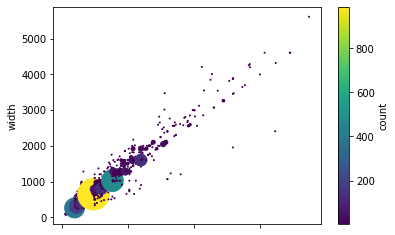

In [42]:
sizes.plot.scatter(x='height', y='width',c='count',s=sizes['count'],colormap='viridis')


- Images are of multiple sizes from very small range in 50s to high as 3k
- Majority of images are in 480x640 having 989 occurances
- Multiple images of odd sizes having higly low or high height and width
- Car images are of differnt colours and types

#### Edege detection of images

In [43]:
def edgeDetection(image):

    plt.imshow(image, cmap='gray')
    # 3x3 sobel filter for horizontal edge detection
    sobel_y = np.array([[ -1, -2, -1], 
                       [ 0, 0, 0], 
                       [ 1, 2, 1]])
    # vertical edge detection
    sobel_x = np.array([[-1, 0, 1],
                       [-2, 0, 2],
                       [-1, 0, 1]])
    # filter the image using filter2D(grayscale image, bit-depth, kernel)  
    filtered_image1 = cv2.filter2D(image, -1, sobel_x)
    filtered_image2 = cv2.filter2D(image, -1, sobel_y)
    f, ax = plt.subplots(1, 2, figsize=(15, 4))
    ax[0].set_title('horizontal edge detection')
    ax[0].imshow(filtered_image1, cmap='gray')
    ax[1].set_title('vertical edge detection')
    ax[1].imshow(filtered_image2, cmap='gray')

In [44]:
#capture basic details of images
def imgBasics(pic):
    
    plt.figure(figsize = (5,5))
    plt.imshow(pic)

    #Basic properties of image
    print('Type of the image : ' , type(pic)) 
    print('Shape of the image : {}'.format(pic.shape)) 
    print('Image Hight {}'.format(pic.shape[0])) 
    print('Image Width {}'.format(pic.shape[1])) 
    print('Dimension of Image {}'.format(pic.ndim))
    print('Image size {}'.format(pic.size)) 
    print('Maximum RGB value in this image {}'.format(pic.max())) 
    print('Minimum RGB value in this image {}'.format(pic.min()))
    print('Value of only R channel {}'.format(pic[ 100, 50, 0])) 
    print('Value of only G channel {}'.format(pic[ 100, 50, 1])) 
    print('Value of only B channel {}'.format(pic[ 100, 50, 2]))

Type of the image :  <class 'numpy.ndarray'>
Shape of the image : (768, 1024, 3)
Image Hight 768
Image Width 1024
Dimension of Image 3
Image size 2359296
Maximum RGB value in this image 255
Minimum RGB value in this image 0
Value of only R channel 41
Value of only G channel 41
Value of only B channel 41


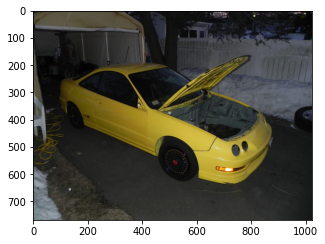

In [45]:
img1 = getImage(path1,df_train,4)
img2 = getImage(path2,df_test,4)
imgBasics(img1)


Type of the image :  <class 'numpy.ndarray'>
Shape of the image : (409, 799, 3)
Image Hight 409
Image Width 799
Dimension of Image 3
Image size 980373
Maximum RGB value in this image 255
Minimum RGB value in this image 0
Value of only R channel 233
Value of only G channel 242
Value of only B channel 247


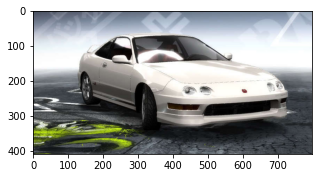

In [46]:
imgBasics(img2)

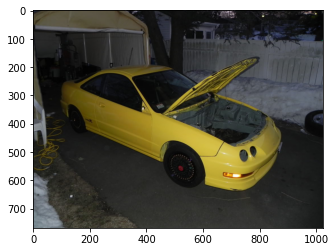

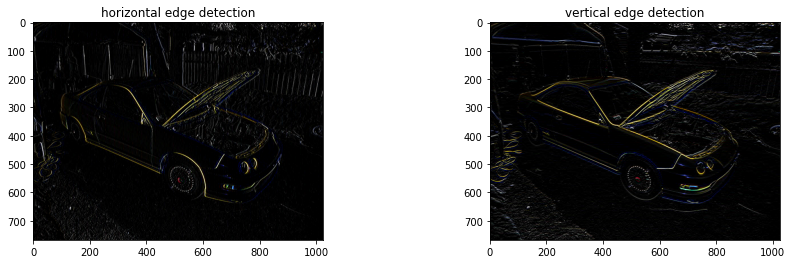

In [47]:
edgeDetection(img1)

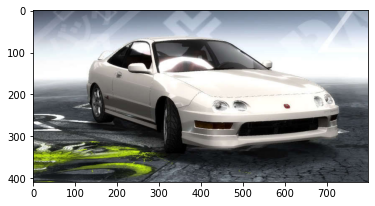

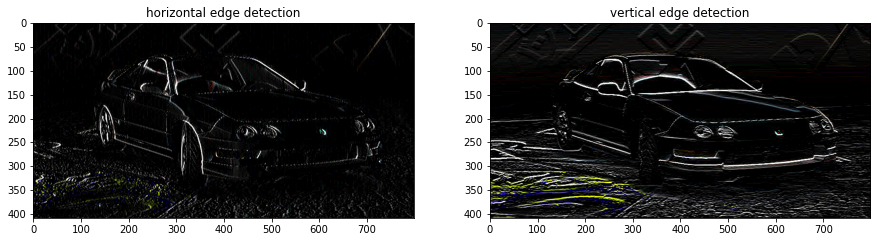

In [48]:
edgeDetection(img2)

###### Resizing

In [49]:
def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding'''
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    #print(new_h,new_w)
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 0)
 
    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas

In [50]:
def viewUpdatedImg(image,bbox):
    im=cv2.rectangle(image.copy(), (bbox[0],bbox[1]), (bbox[2],bbox[3]), (0,180,0), 1)
    plt.imshow(im)

In [51]:
 def loadImage(path,df,i):
    im = cv2.imread(str('{}/{}/{}'.format(path, df.fol_details[i],df.file_name[i])))[:,:,::-1]
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)#change color space
    #cv2.rectangle(im,( int(df.x1[i]),int(df.y1[i])), (int(df.x2[i]),int(df.y2[i])), (0,255,0), 2)
    return im

def loadImgWithBbox(path, df,i):
    img=loadImage(path, df,i)
    bboxes=np.array([df.x1[i],df.y1[i],df.x2[i],df.y2[i]])
    return img, bboxes

In [52]:
def resize(img, bboxes,inp_dim):
 
    
    w,h = img.shape[1], img.shape[0]
    img = letterbox_image(img, inp_dim)


    scale = min(inp_dim[1]/h, inp_dim[0]/w)
    bboxes[:4] = bboxes[:4]  * (scale)

    new_w = scale*w
    new_h = scale*h
    inp_dim = inp_dim   

    del_h = (inp_dim[1] - new_h)/2
    del_w = (inp_dim[0] - new_w)/2

    add_matrix = np.array([[del_w, del_h, del_w, del_h]]).astype(int)

    bboxes[:4] = bboxes[:4] + add_matrix

    img = img.astype(np.uint8)

    return img, bboxes

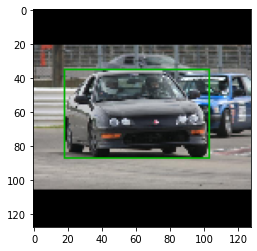

In [53]:
img,bboxes=loadImgWithBbox(path1,df_train,5)
img,bboxes=resize(img,bboxes,(128,128))
viewUpdatedImg(img,bboxes)

In [54]:
print(type(img))
print(type(bboxes))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### Resize without clipbox boundries logic

In [55]:
def resizeWithoutLetterBox(img, bboxes,inp_dim):
 
    
    w,h = img.shape[1], img.shape[0]

    x_scale = inp_dim[0]/w
    y_scale = inp_dim[1]/h
    #print(bboxes)
    #print(x_scale,y_scale)
    img = cv2.resize(img,(inp_dim))
    img = np.array(img)
    
    
    x = int(np.ceil(bboxes[0]*x_scale))
    y = int(np.ceil(bboxes[1]*y_scale))
    xmax= int(np.ceil(bboxes[2]*(x_scale)))
    ymax= int(np.ceil(bboxes[3]*y_scale))
    

    bboxes[:4] =  np.array([[x, y, xmax, ymax]]).astype(int)
    #print(bboxes)
   

    img = img.astype(np.uint8)

    return img, bboxes

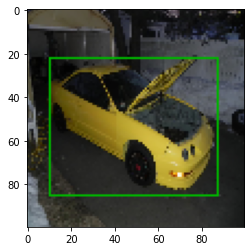

In [56]:
img,bboxes=loadImgWithBbox(path1,df_train,4)
img,bboxes=resizeWithoutLetterBox(img,bboxes,(100,100))
viewUpdatedImg(img,bboxes)

###### HOrizontal flip

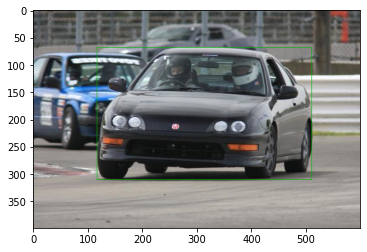

In [57]:
def horzFlip(img, bboxes):
    #print(bboxes)
    img_center = np.array(img.shape[:2])[::-1]/2
    img_center = np.hstack((img_center, img_center))

    img =  img[:,::-1,:]
    bboxes[[0,2]] = bboxes[[0,2]] + 2*(img_center[[0,2]] - bboxes[[0,2]])
    #print(bboxes)
    box_w = abs(bboxes[0] - bboxes[2])
    bboxes[0] = bboxes[0] - box_w
    bboxes[2] = bboxes[2] + box_w
    #print(bboxes)
    
    return img, bboxes

img,bboxes=loadImgWithBbox(path1,df_train,5)
img,bboxes=horzFlip(img,bboxes)
viewUpdatedImg(img,bboxes)

###### Scaling

In [58]:
def clip_box(bbox, clip_box):

    ar_ = (bbox_area(bbox))
    bbox[0] = np.maximum(bbox[0], clip_box[0])
    bbox[1] = np.maximum(bbox[1], clip_box[1])
    bbox[2] = np.minimum(bbox[2], clip_box[2])
    bbox[3] = np.minimum(bbox[3], clip_box[3])
    #print(x_min)
    #bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[4:]))
    #print(bbox)
    #delta_area = ((ar_ - bbox_area(bbox))/ar_)
    
    #mask = (delta_area < (1 - alpha)).astype(int)
    
    #bbox = bbox[mask == 1,:]


    return bbox

def bbox_area(bbox):
    return (bbox[2] - bbox[0])*(bbox[3] - bbox[1])

def scaleImage(img,bboxes,scale,diff):
    
    if (type(scale) == tuple):
        assert len(scale) == 2, "Invalid range"
        assert scale[0] > -1, "Scale factor can't be less than -1"
        assert scale[1] > -1, "Scale factor can't be less than -1"
    else:
        assert scale > 0, "Please input a positive float"
        scale = (max(-1, -scale), scale)
        
     
    img_shape = img.shape
        
    if diff:
        scale_x = random.uniform(*scale)
        scale_y = random.uniform(*scale)
    else:
        scale_x = random.uniform(*scale)
        scale_y = scale_x

    resize_scale_x = 1 + scale_x
    resize_scale_y = 1 + scale_y

    img=  cv2.resize(img, None, fx = resize_scale_x, fy = resize_scale_y)

    bboxes[:4] = bboxes[:4]  * [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]
    
    canvas = np.zeros(img_shape, dtype = np.uint8)
    
    y_lim = int(min(resize_scale_y,1)*img_shape[0])
    x_lim = int(min(resize_scale_x,1)*img_shape[1])

    canvas[:y_lim,:x_lim,:] =  img[:y_lim,:x_lim,:]

    img = canvas
    
    bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]])
    
    return img, bboxes

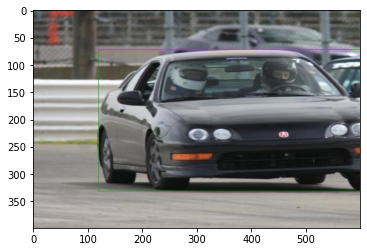

In [59]:
img,bboxes=loadImgWithBbox(path1,df_train,5)
img,bboxes=scaleImage(img,bboxes,0.4,True)
viewUpdatedImg(img,bboxes)

###### Translate Image

In [60]:
def translateImage(img,bboxes,translate,diff):
    
    if type(translate) == tuple:
        assert len(translate) == 2, "Invalid range"  
        assert translate[0] > 0 and translate[0] < 1
        assert translate[1] > 0 and translate[1] < 1
    else:
        assert translate > 0.0 and translate < 1.0
        translate = (-translate, translate)
    
    img_shape = img.shape
        
    translate_factor_x = random.uniform(*translate)
    translate_factor_y = random.uniform(*translate)
    
    if not diff:
        translate_factor_y = translate_factor_x
        
    canvas = np.zeros(img_shape).astype(np.uint8)
    
    corner_x = int(translate_factor_x*img.shape[1])
    corner_y = int(translate_factor_y*img.shape[0])
    
    orig_box_cords =  [max(0,corner_y), 
                       max(corner_x,0), 
                       min(img_shape[0], corner_y + img.shape[0]), 
                       min(img_shape[1],corner_x + img.shape[1])
                      ]
    
    mask = img[max(-corner_y, 0):min(img.shape[0], -corner_y + img_shape[0]), max(-corner_x, 0):min(img.shape[1], -corner_x + img_shape[1]),:]
    canvas[orig_box_cords[0]:orig_box_cords[2], orig_box_cords[1]:orig_box_cords[3],:] = mask
    img = canvas
    
    bboxes[:4] = bboxes[:4] + [corner_x, corner_y, corner_x, corner_y]
    
    bboxes = clip_box(bboxes, [0,0,img_shape[1], img_shape[0]])
    
    return img, bboxes

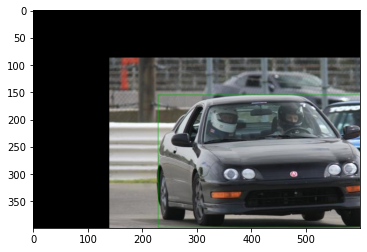

In [61]:
img,bboxes=loadImgWithBbox(path1,df_train,5)
img,bboxes=translateImage(img,bboxes,0.4,True)
viewUpdatedImg(img,bboxes)

###### Rotate

In [62]:


#rotate_im
def rotate_im(image, angle):

    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    #center = tuple(np.array(image.shape)[:2]/2)

    # print(angle[0],cX,cY)
    
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    image = cv2.warpAffine(image, M, (nW, nH))

#    image = cv2.resize(image, (w,h))
    return image

def get_corners(bboxes):
    
    width = (bboxes[2] - bboxes[0]).reshape(-1,1)
    height = (bboxes[3] - bboxes[1]).reshape(-1,1)
    
    x1 = bboxes[0].reshape(-1,1)
    y1 = bboxes[1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[2].reshape(-1,1)
    y4 = bboxes[3].reshape(-1,1)
    
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners

def rotate_box(corners,angle,  cx, cy, h, w):


    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated

def get_enclosing_box(corners):

    x_ = corners[[0,2,4,6]]
    y_ = corners[[1,3,5,7]]
    
    
    xmin = np.min(x_).reshape(-1,1)
    ymin = np.min(y_).reshape(-1,1)
    xmax = np.max(x_).reshape(-1,1)
    ymax = np.max(y_).reshape(-1,1)
    
    #print(xmin,xmin[0])
    
    final = np.hstack((xmin[0], ymin[0], xmax[0], ymax[0],corners[8:]))
    
    return final

def rotateImageBBox(img,bboxes,angle):
    
    
    if type(angle) == tuple:
        assert len(angle) == 2, "Invalid Range"
    else:
        angle = (-angle,angle)
    
    angle = random.uniform(*angle)
    
    w,h = img.shape[1], img.shape[0]
    cx, cy = w//2, h//2
    
    img = rotate_im(img, angle)

    corners = get_corners(bboxes)

    corners = np.hstack((corners[0], bboxes[4:]))


    corners[:8] = rotate_box(corners[:8], angle, cx, cy, h, w)

    new_bbox = get_enclosing_box(corners)


    scale_factor_x = img.shape[1] / w

    scale_factor_y = img.shape[0] / h

    img = cv2.resize(img, (w,h))

    new_bbox[:4] = new_bbox[:4]  / [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 

    bboxes  = new_bbox

    bboxes = clip_box(bboxes, [0,0,w, h])

    return img, bboxes

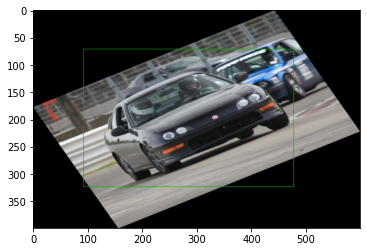

In [63]:
img,bboxes=loadImgWithBbox(path1,df_train,5)
img,bboxes=rotateImageBBox(img,bboxes,30.0)
viewUpdatedImg(img,bboxes)

###### Shearing

In [64]:
def shearImage(img,bboxes,shear_factor):
 
    if type(shear_factor) == tuple:
        assert len(shear_factor) == 2, "Invalid range for scaling factor"   
    else:
        shear_factor = (-shear_factor, shear_factor)
        
    shear_factor = random.uniform(*shear_factor)          
     
    w,h = img.shape[1], img.shape[0]

    if shear_factor < 0:
        img, bboxes = horzFlip(img,bboxes)

    M = np.array([[1, abs(shear_factor), 0],[0,1,0]])

    nW =  img.shape[1] + abs(shear_factor*img.shape[0])

    bboxes[[0,2]] = bboxes[[0,2]] + ((bboxes[[1,3]]) * abs(shear_factor) ).astype(int) 


    img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))

    if shear_factor < 0:
        img, bboxes = horzFlip(img,bboxes)

    img = cv2.resize(img, (w,h))

    scale_factor_x = nW / w

    bboxes[:4] = bboxes[:4] / [scale_factor_x, 1, scale_factor_x, 1] 


    return img, bboxes

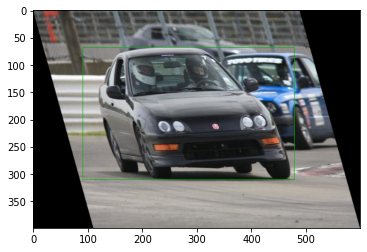

In [65]:
img,bboxes=loadImgWithBbox(path1,df_train,5)
img,bboxes=shearImage(img,bboxes,0.7)
viewUpdatedImg(img,bboxes)

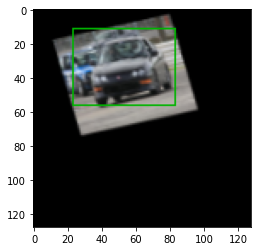

In [66]:
img,bboxes=loadImgWithBbox(path1,df_train,5)
img1,bboxes1=resize(img,bboxes,(128,128))

img2,bboxes2 = horzFlip(img1,bboxes1)
img2,bboxes2 = scaleImage(img2,bboxes2,0.4,True)
img2,bboxes2 = translateImage(img2,bboxes2,0.2,True)
img2,bboxes2 = rotateImageBBox(img2,bboxes2,30.0)
img2,bboxes2 = shearImage(img2,bboxes2,0.5)


viewUpdatedImg(img2,bboxes2)

###### Load images for model  into a single array

In [67]:
df_train.loc[df_train['class_Id']==6]

,file_name,fol_details,x1,y1,x2,y2,class_Id
0,00198.jpg,Acura Integra Type R 2001,91,121,574,357,6
1,00255.jpg,Acura Integra Type R 2001,29,78,734,396,6
2,00308.jpg,Acura Integra Type R 2001,16,136,775,418,6
3,00374.jpg,Acura Integra Type R 2001,9,184,740,499,6
4,00878.jpg,Acura Integra Type R 2001,101,162,882,650,6
5,00898.jpg,Acura Integra Type R 2001,89,68,483,310,6
6,01010.jpg,Acura Integra Type R 2001,6,3,932,639,6
7,01012.jpg,Acura Integra Type R 2001,58,72,763,529,6
8,01255.jpg,Acura Integra Type R 2001,17,80,735,492,6
9,01617.jpg,Acura Integra Type R 2001,62,150,543,339,6


In [68]:
filelist[1]

'data/Car Images-20210501T094840Z-001/Car Images/Train Images\\Acura Integra Type R 2001\\00255.jpg'

In [69]:
#for col_name, data in df_train.items():
#    print("col_name:",col_name, "\ndata:",data)

#for i, row in df_train.iterrows():
#    #print(f"Index: {i}")
#    print(f"{row['file_name']}\n")


In [109]:
from keras.preprocessing import image
def loadFileForModelling(path,df):

    train_img = []
    label_img = []
    bboxes_coord = []
    for i, row in df.iterrows():
        #img = imread(file)
        #img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        #img_pred = cv.resize(img, (img_height, img_width), interpolation=cv.INTER_AREA)
        #img_pred = image.img_to_array(img_pred)
        #img_pred = img_pred / 255
        
        img = cv2.imread(str('{}/{}/{}'.format(path, row['fol_details'],row['file_name'])))[:,:,::-1]
        

        bboxes=np.array([row['x1'],row['y1'],row['x2'],row['y2']])
        
        
        #img1,bboxes1 = resize(img,bboxes,(img_height,img_width))
        #Alt func for resizing without aspect ratio to reduce black dominance and box structure
        img1,bboxes1 = resizeWithoutLetterBox(img,bboxes,(img_height,img_width))
        

        
        #img2,bboxes2 = horzFlip(img1,bboxes1)
        #img2,bboxes2 = scaleImage(img2,bboxes2,0.4,True)
        #img2,bboxes2 = translateImage(img2,bboxes2,0.2,True)
        #img2,bboxes2 = rotateImageBBox(img2,bboxes2,30.0)
        #img2,bboxes2 = shearImage(img2,bboxes2,0.5)
        
        
              
        img1=img1/255        
        train_img.append(img1)
        label_img.append(row['class_Id'])
        bboxes_coord.append(bboxes1)
        
        
        #img2 = img2/255        
        #train_img.append(img2)
        #label_img.append(row['class_Id'])
        #bboxes_coord.append(bboxes2)
         
       
    X = np.array(train_img)
    y = np.array(label_img)
    c = np.array(bboxes_coord)
    return X,y,c

gc.collect()

2302

In [110]:
X_train,y_train,c_train=loadFileForModelling(path1, df_train)


gc.collect()


X_test,y_test,c_test=loadFileForModelling(path2, df_test)

In [111]:
X_train.shape

(8144, 100, 100, 3)

In [112]:
c_train.shape

(8144, 4)

In [113]:
y_train[0]

6

In [114]:
c_train[0]

array([16, 27, 96, 80])

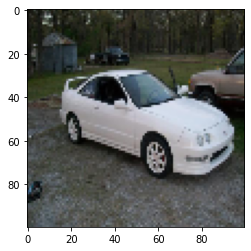

In [115]:
plt.imshow(X_train[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


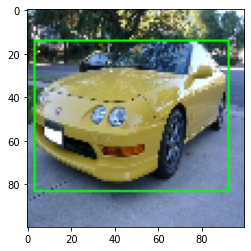

In [116]:
viewUpdatedImg(X_train[8],c_train[8])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


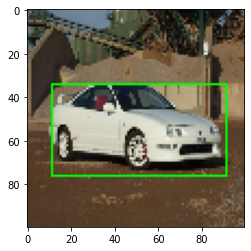

In [117]:
viewUpdatedImg(X_train[9],c_train[9])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


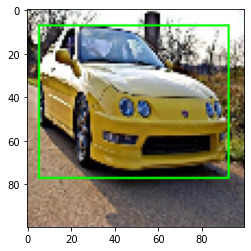

In [118]:
viewUpdatedImg(X_test[10],c_test[10])

- Images and bounding boxes are succesfully moved

In [80]:
from sklearn.preprocessing import OneHotEncoder


one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train.reshape(-1, 1))

y_train = one_hot_encoder.transform(y_train.reshape(-1, 1))

print("Shape of y:", y_train.shape)


Shape of y: (16288, 196)


In [81]:
y_test=one_hot_encoder.transform(y_test.reshape(-1,1))

In [82]:
#expeected at 6
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [83]:
#Making validation data set from test

In [84]:
from sklearn.model_selection import train_test_split
X_valSplit, X_testSplit, y_valSplit, y_testSplit = train_test_split(X_test,y_test, random_state=42, test_size=0.5)